In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm
import matplotlib

In [174]:
matplotlib.rcParams.update({
    'font.size': 15,
    'font.sans-serif': 'Arial',
    'axes.titlepad': 15,
    'axes.titlesize': 20
})

In [ ]:
from sklearn.datasets import make_blobs

X, y = make_blobs(centers=4, n_features=2, n_samples=100, cluster_std=[1.5, 2., 1.8, 1.5], random_state=43)

In [56]:
import torch
import torch.distributions as dist
import math

In [104]:
X = torch.from_numpy(X).float()

In [58]:
def variational_e_step(X, alpha, beta, nu, m, W):
    log_pi = torch.digamma(alpha) - torch.digamma(alpha.sum())
    log_lambda = torch.digamma((nu[:, None] - torch.arange(D).reshape(1, D))/2).sum(dim=1) + D*math.log(2) + torch.logdet(W)
    diffs = X[:, None, :] - m[None, :, :]
    W_chol = torch.linalg.cholesky(W)
    exponent = ((torch.einsum('kdj,nkd->nkj', W_chol, diffs)) ** 2).sum(dim=2)
    log_rho = log_pi + 0.5 * log_lambda - 0.5 * (D/beta + nu*exponent) - D/2*math.log(2*math.pi)
    rho_norm = torch.logsumexp(log_rho, dim=1)
    gamma = (log_rho - rho_norm[:, None]).exp()
    return gamma

In [59]:
def variational_m_step(X, gamma):
    N_k = gamma.sum(dim=0)
    alpha = alpha0 + N_k
    beta = beta0 + N_k
    nu = nu0 + N_k
    x_bar = torch.mm(gamma.T, X) / N_k[:, None]
    diffs = X[:, None, :] - x_bar[None, :, :]
    S = torch.einsum('nkdj,nkjt->nkdt', diffs[:, :, :, None], diffs[:, :, None, :])
    S = (S * gamma[:, :, None, None]).sum(dim=0) / N_k[:, None, None]

    diffs2 = x_bar - m0
    m = (m0 * beta0 + x_bar * N_k[:, None]) / beta[:, None]
    W_inv = W0.inverse()[None, :, :] + S * N_k[:, None, None] + \
        (beta0 * N_k / (beta0 + N_k))[:, None, None] * torch.einsum('ki,kj->kij', diffs2, diffs2)
    W = W_inv.inverse()
    return alpha, beta, nu, m, W

In [60]:
def multivariate_studentt(X, m, L, nu):
    _, D = X.shape
    diff = X - m
    delta2 = (diff.mm(L) * diff).sum(dim=1)
    coeff = torch.lgamma( (nu + D)/2 ) - torch.lgamma(nu/2) + 0.5*torch.logdet(L) - D/2 * torch.log(nu*math.pi)
    return coeff - 0.5*(nu + D)*torch.log(1+delta2/nu)  

def _calc_log_prob(X, K, alpha, beta, nu, m, W):
    
    L = ((nu + 1 - D) * beta / (1 + beta))[:, None, None] * W
    df = nu + 1 - D
    
    log_prob = []
    for i in range(K):
        log_prob.append(multivariate_studentt(X, m[i], L[i], df[i]))
    log_prob = torch.stack(log_prob).T
    log_prob = log_prob + torch.log(alpha/alpha.sum())[None, :]
    return log_prob

def predict_log_prob(X, K, alpha, beta, nu, m, W):
    log_prob = _calc_log_prob(X, K, alpha, beta, nu, m, W)
    return torch.logsumexp(log_prob, dim=1)

def predict_label(X, K, alpha, beta, nu, m, W):
    log_prob = _calc_log_prob(X, K, alpha, beta, nu, m, W)
    return  log_prob.argmax(dim=1)

In [ ]:
TOL = 1e-6
D = 2
K = 4
N = len(X)

alpha0 = 1
beta0 = 1
nu0 = 2
alpha = (alpha0 + N / K) * torch.ones(K)
beta = (beta0 + N / K) * torch.ones(K)
nu = (nu0 + N / K) * torch.ones(K)
m0 = torch.zeros(D)
W0 = torch.eye(D)
sample_idx = torch.randint(0, N, size=(K,))
m = X[sample_idx]
W = torch.tile(m.var(dim=0).diag(), (K, 1, 1))

for i in range(1000):
    gamma = variational_e_step(X, alpha, beta, nu, m, W)
    _alpha, _beta, _nu, _m, _W = variational_m_step(X, gamma)

    if torch.allclose(alpha, _alpha, TOL) and torch.allclose(beta, _beta, TOL) and torch.allclose(m, _m, TOL) and torch.allclose(_W, W, TOL):
        print('finish @ iter %d' % i)
        alpha, beta, nu, m, W = _alpha, _beta, _nu, _m, _W
        break
    alpha, beta, nu, m, W = _alpha, _beta, _nu, _m, _W

In [133]:
def get_meshgrid(x, y, nx, ny, margin=0.1):
    x_min, x_max = (1 + margin) * x.min() - margin * x.max(), (1 + margin) * x.max() - margin * x.min()
    y_min, y_max = (1 + margin) * y.min() - margin * y.max(), (1 + margin) * y.max() - margin * y.min()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    return torch.from_numpy(xx).float(), torch.from_numpy(yy).float()
xx, yy = get_meshgrid(X[:, 0], X[:, 1], nx=100, ny=100, margin=0.1)

In [134]:
coords = torch.stack([xx.ravel(), yy.ravel()]).T

In [185]:
scores = predict_log_prob(coords, K, alpha, beta, nu, m, W)
labels = predict_label(coords, K, alpha, beta, nu, m, W)

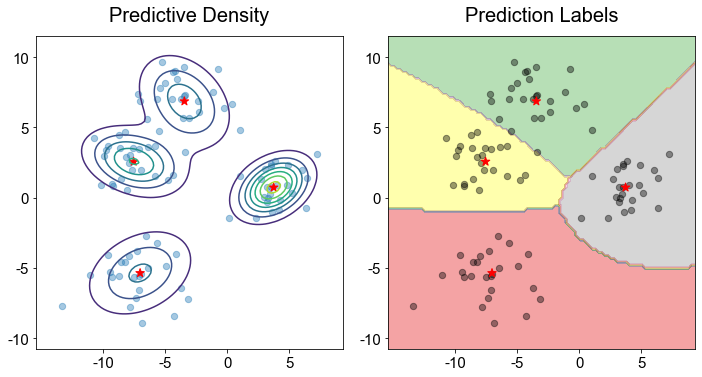

In [187]:
plt.figure(figsize=(10, 5.5))

plt.subplot(1, 2, 1)
contour = plt.contour(xx.numpy(), yy.numpy(), scores.reshape(xx.shape).exp(), cmap='viridis')#, norm=LogNorm(vmin=1, vmax=180), levels=np.logspace(0, 2.2, 20), cmap='jet')
plt.scatter(X[:, 0], X[:, 1], s=40, alpha=0.4)
plt.scatter(m[:, 0], m[:, 1], marker='*', s=[80]*K, c='r')
plt.title('Predictive Density')
plt.xticks(np.arange(-10, 10, 5), np.arange(-10, 10, 5))
plt.yticks(np.arange(-10, 15, 5), np.arange(-10, 15, 5))

plt.subplot(1, 2, 2)
plt.contourf(xx, yy, labels.reshape(xx.shape), alpha=0.4, cmap='Set1')
plt.scatter(X[:, 0], X[:, 1], s=40, c='k', alpha=0.4)
plt.scatter(m[:, 0], m[:, 1], marker='*', s=[80]*K, c='r')
plt.xticks(np.arange(-10, 10, 5), np.arange(-10, 10, 5))
plt.yticks(np.arange(-10, 15, 5), np.arange(-10, 15, 5))
plt.title('Prediction Labels')

plt.tight_layout()